# 1. Load packages

In [1]:
!pip install git+https://github.com/Joeclinton1/google-images-download.git

  Cloning https://github.com/Joeclinton1/google-images-download.git to /tmp/pip-req-build-7qpjgt12
  Running command git clone -q https://github.com/Joeclinton1/google-images-download.git /tmp/pip-req-build-7qpjgt12
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=15501 sha256=e589e3c9e850b27738359f523abba6231fab49b843f58e6d4841056b17f76906
  Stored in directory: /tmp/pip-ephem-wheel-cache-lu7jw4hz/wheels/50/f1/1c/089cebf505dc8e8f87f61a21a439652bc53e39ebb2c3f6767e
Successfully built google-images-download


In [1]:
import torchvision.transforms as transforms
from skimage.color import gray2rgb
import numpy as np
import os
import sys
import json
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.spatial import KDTree
from torch.autograd import Variable

from google_images_download import google_images_download   #importing the library

from fnmatch import fnmatch

from PIL import Image

from skimage.transform import rescale, resize, downscale_local_mean

from tqdm import tqdm

# 2. Downloading Images
Since this example is just a demo we will download images from google. We have selected a few materials catagories but you can use whatever catagories you like. You can also use your own images. 

In [2]:
def download_images_from_google(names, path, num=25, verbose=True):
    
    # instantiation of the class to download images
    response = google_images_download.googleimagesdownload()
    
    # converts the list to a string
    names = ''.join(str(i+',') for i in names)
    
    # creating list of arguments
    arguments = ({"keywords":names,
                  "limit":num,"print_urls":verbose,
                 "output_directory":path}) 
    
    #passing the arguments to the function
    paths = response.download(arguments)   


In [31]:
path = './downloads/'

names = ['transmission electron microscopy', 'atomic force microscopy', 'optical microscopy', 'metals',
        'ceramics', 'polymers','semiconductors']


download_images_from_google(names, path)


Item no.: 1 --> Item name = transmission electron microscopy
Evaluating...
Starting Download...
Image URL: https://cdn.britannica.com/90/113690-004-CB552E7F/Transmission-electron-microscope.jpg
Completed Image ====> 1.transmission-electron-microscope.jpg
Image URL: https://warwick.ac.uk/fac/sci/physics/current/postgraduate/regs/mpagswarwick/ex5/techniques/structural/tem/tem_ed.jpg
Completed Image ====> 2.tem_ed.jpg
Image URL: https://www.ccber.ucsb.edu/sites/default/files/Electron_Microscope.jpg
Completed Image ====> 3.electron_microscope.jpg
Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/STEM_fig.png/1200px-STEM_fig.png
Completed Image ====> 4.1200px-stem_fig.png
Image URL: https://www.news-medical.net/image.axd?picture=TEM%20schwann%20cell%20-%20Jose%20Luis%20Calvo%20_thumb%5B8%5D_thumb.jpg
Completed Image ====> 5.image.axd.jpg
Image URL: https://microbenotes.com/wp-content/uploads/2020/03/Transmission-Electron-Microscope-TEM.jpeg
Completed Image ====> 6.transm

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Expecting value: line 1 column 1 (char 0)
Image objects data unpacking failed. Please leave a comment with the above error at https://github.com/hardikvasa/google-images-download/pull/298
Traceback (most recent call last):
  File "/home/bellefonte/anaconda3/envs/fastai-3.6/lib/python3.6/site-packages/google_images_download/google_images_download.py", line 234, in download_page
    return self._image_objects_from_pack(self._extract_data_pack(respData)), self.get_all_tabs(respData)
  File "/home/bellefonte/anaconda3/envs/fastai-3.6/lib/python3.6/site-packages/google_images_download/google_images_download.py", line 199, in _image_objects_from_pack
    image_objects = json.loads(data)[31][0][12][2]
  File "/home/bellefonte/anaconda3/envs/fastai-3.6/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/home/bellefonte/anaconda3/envs/fastai-3.6/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end()

SystemExit: 

/home/bellefonte/anaconda3/envs/fastai-3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [32]:
def image_collection(path, pattern = "*.jpg"):
    
    #Create a directory of all file paths
    dir_jpg=[]
    for path, subdirs, files in os.walk(path):
        for name in files:
            if fnmatch(name, pattern):
                file_path=os.path.normpath(os.path.join(path,name))
                dir_jpg.append(file_path)
    dir_jpg.sort()
    
    # saves images as a numpy array
    images_=[]
    for i in range(len(dir_jpg)):
        im = Image.open(dir_jpg[i])
        images_.append(im)
        
    dir_name=[]
    name_all=[]
    for ind, name in enumerate(dir_jpg):
        path, name = os.path.split(dir_jpg[ind])
        name = name.split('/')[-1][:-4].lower()
        dir_name.append(name[:2])
        name_all.append(name)
        
    return images_, dir_jpg, name_all, dir_name

In [58]:
path = './downloads/'
images, dir_jpg, name_all, dir_name = image_collection(path)

In [59]:
class image_dataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, images, transform=None):
        'Initialization'
        self.images = images
        self.transform = transform
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.images[index].convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        return image

# way to deal with gray images. 
transform = transforms.Compose([
            #transforms.ToPILImage(),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

In [60]:
batch_size = 5
cropped_dataset = image_dataset(images=images, transform=transform)
train_dl = DataLoader(cropped_dataset, batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [61]:
len(cropped_dataset)

128

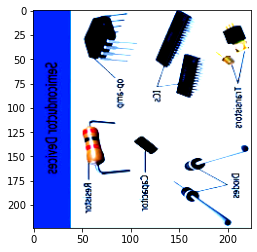

In [38]:
plt.imshow(torch.transpose(cropped_dataset.__getitem__(100),0,2))

In [39]:
# Set the parameters and CUDA, CPU useage
# Make this into a function

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}

# TODO (Shuyu's notes)

1. Make it so the user can select which models to use as feature extractors
2. If they select both models we want to train the 1 layer autoencoder for a few epochs (5) and then concatonate the two feature vectors. 
3. Pass this through the rest of the notebook to generate what is needed for the interactive portion (Tri can help you here if needed).

In [9]:
# Set the RseNet Model, espectiallly load the weights and save the model
# for further usage 

# Create the Function that allows users to select the model as feature extractor (VGG16, ResNet34, or both)

In [40]:
import os 
import sys

In [41]:
import select_model as s_m

In [42]:
test_vgg = s_m.select_model(train_dl,5,images,model_type='vgg', N_EPOCHS=5)

Using cache found in /home/bellefonte/.cache/torch/hub/pytorch_vision_v0.6.0


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
(128, 4096)


## 4. Processing images


In [88]:
#Normalize the images if needed

# from sklearn.preprocessing import normalize
# from sklearn import preprocessing


# def get_image(ind):
    
#     min_max_scaler = preprocessing.MinMaxScaler()
    
# #     image = np.load(dir_PFM_new[ind]) #Load the images from dir_PFM2 (flattened images), not dir_PFM (unflattened images)
#     image = np.array(Image.open(dir_jpg[ind]))
#     if image.ndim ==2:
# #         image = np.repeat(image[..., np.newaxis], 3, -1)
#         image = gray2rgb(image)
    
#     if np.max(image.reshape(-1))< 1.1:
#         img_norm = image*255
#     else: 
#         img_norm = image
    
#     #Normalizaing the images
#     #img_a = image[:,:,0]*255
#     #img_b = image[:,:,1]*255
#     #img_c = image[:,:,2]*255

#     #img_norm = np.empty(image.shape, dtype=np.float32)
#     #img_norm[:, :, 0] = img_c
#     #img_norm[:, :, 1] = img_b
#     #img_norm[:, :, 2] = img_a


#     image_resized = resize(img_norm[:,:,:],(224,224,3), )
#     image = resize(img_norm[:,:,:],(224,224,3))
    
   
#     image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2])) #reshape data for the model
#     #image = preprocess_input(image) #prepare the image for the model
    
#     return image

In [51]:
#Process images for VGG16 (this one works for Tensforflow code)

# def get_image(ind):
    
# #     image = np.load(dir_PFM_new[ind]) #Load the images from dir_PFM2 (flattened images), not dir_PFM (unflattened images)
#     image = np.array(Image.open(dir_jpg[ind]))
#     if image.ndim ==2:
# #         image = np.repeat(image[..., np.newaxis], 3, -1)
#         image = gray2rgb(image)
#     #Normalizaing the images
#     img_a = min_max_scaler.fit_transform(image[:,:,0])*255
#     img_b = min_max_scaler.fit_transform(image[:,:,1])*255
#     img_c = min_max_scaler.fit_transform(image[:,:,2])*255

#     img_norm = np.empty(image.shape, dtype=np.float32)
#     img_norm[:, :, 0] = img_a
#     img_norm[:, :, 1] = img_b
#     img_norm[:, :, 2] = img_c


#     image_resized = resize(img_norm[:,:,:],(224,224,3))
#     image = resize(img_norm[:,:,:],(224,224,3))
    
   
#     image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2])) #reshape data for the model
#     image = preprocess_input(image) #prepare the image for the model

#     image_processed = get_21st_layer_output([image])[0] # Extract fc2 layer output. We don't want to use the last layer 
    
#     return image_resized, image_processed
    

## 5. Plot UMAP

In [74]:
#PLotting method

from matplotlib import offsetbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import random

def imscatter(x, y, images, number_images_shown, ax=None, zoom=1.0 ):
        if ax is None:
            ax = plt.gca()
        x, y = np.atleast_1d(x, y)
        artists = []
        
        shown_images=[]
        x1=[]
        y1=[]

        r= random.sample(range(len(images)),number_images_shown)
        r.sort()
        for i in r:
            
            shown_images.append(images[i])
            x1.append(x[i])
            y1.append(y[i])
            
        for x0, y0, img0 in zip (x1, y1, shown_images):
#             im = OffsetImage(img0[:,:,:].astype(np.uint8), zoom=zoom)
            im = OffsetImage(img0[:,:,:].astype(np.uint8), zoom=zoom)
            ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False, pad=0)
            artists.append(ax.add_artist(ab))
        ax.update_datalim(np.column_stack([x, y]))
        ax.autoscale()
        return artists

def plot_embedding(X, number_images_shown, size, imgs):
        #Reset to limit of axes to [0,1]
        x_min, x_max = np.min(X, 0), np.max(X, 0)
        X = ((X - x_min) / (x_max - x_min))*size

        plt.figure(figsize=(size, size))
        plt.rcParams['savefig.facecolor'] = "0"
        plt.rcParams['figure.facecolor'] = "1"
                    
        ax = plt.subplot(111, frameon=False)
        #ax.axis("off")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        if hasattr(offsetbox, 'AnnotationBbox'):
            imscatter(X[:, 0],  X[:, 1], imgs,  number_images_shown, zoom=0.1, ax=ax)
        
        plt.xlim(np.min(X[:,0]),np.max(X[:,0]))
        plt.ylim(np.min(X[:,1]),np.max(X[:,1]))
      
        plt.tight_layout(pad=0,h_pad=0,w_pad=0)
        plt.savefig("test1.png", bbox_inches='tight', pad_inches=0, dpi=300)

#         if title is not None:
#             plt.title(title)

# 6. Run UMAP

In [69]:
#Save the images data for UMAP plotting later

images =[]
for i in range(len(cropped_dataset)):
    images.append(torch.transpose(cropped_dataset.__getitem__(i),0,2).detach().numpy())

images = np.array(images)
    

In [89]:
np.save('Data_images.npy',images) #save images

In [90]:
np.save('Data_activations.npy',test_vgg) #save activations

In [75]:
# Calcualte UMAP activations
import umap
import time

start = time.time()
print("Computing UMAP embedding")
np.random.seed(42)
X_umap = umap.UMAP(n_neighbors=5,min_dist=0.3, n_components=2, metric='correlation').fit_transform(test_vgg)
    
# plot_embedding(X_umap, 1000, images, 'UMAP embedding of' +' {} '.format(X_umap.shape[0]) +'images'+" (1000 images shown)")
    #plt.savefig(filename, bbox_inches='tight', dpi=300)
# plot_embedding(X_umap, X_umap.shape[0], 10, images)    
stop = time.time() #end the timer

print(stop-start)

Computing UMAP embedding
1.2863543033599854


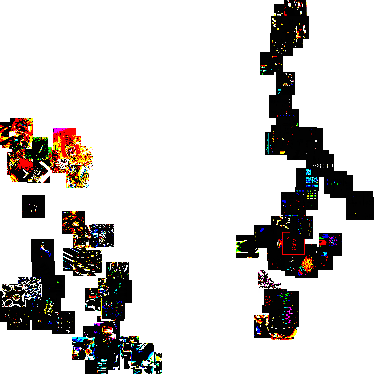

In [79]:
# Plot UMAP
plot_embedding(X_umap, 100, 5, images)    

In [93]:
np.save('Data_umap.npy',X_umap) #save UMAP activations